In [51]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, desc, when, count, concat_ws, length, rand
import pandas as pd
import utils as u

def measure_time(func, *args, **kwargs):
    start = time.perf_counter()
    result = func(*args, **kwargs)
    end = time.perf_counter()
    return result, end - start

measure_time

<function __main__.measure_time(func, *args, **kwargs)>

In [2]:
spark = SparkSession.builder \
    .appName("RAID-EDA") \
    .master("spark://spark-master:7077") \
    .getOrCreate()

spark

In [3]:
df = spark.read.json("hdfs://namenode:8020/user/raid/raw")
df

DataFrame[attack: string, domain: string, features: array<double>, generation: string, id: string, model: string]

In [4]:
df.printSchema()

root
 |-- attack: string (nullable = true)
 |-- domain: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- generation: string (nullable = true)
 |-- id: string (nullable = true)
 |-- model: string (nullable = true)



# Total Baris

In [6]:
print("[1] Menghitung total jumlah baris...")
total_rows, time_1 = measure_time(lambda: df.count())
print(f"✅ Total baris: {total_rows:,} | Waktu: {time_1:.4f} detik")

[1] Menghitung total jumlah baris...
✅ Total baris: 481,356 | Waktu: 4.3322 detik


# Cek missing values

In [8]:
print("[2] Cek missing values (null) per kolom...")
missing_counts, time_2 = measure_time(
    lambda: df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).collect()
)
print(f"✅ Selesai dalam {time_2:.4f} detik")
missing_dict = missing_counts[0].asDict()
for col_name, null_count in missing_dict.items():
    print(f"  - {col_name}: {null_count:,} nulls")

[2] Cek missing values (null) per kolom...
✅ Selesai dalam 9.7229 detik
  - attack: 0 nulls
  - domain: 0 nulls
  - features: 0 nulls
  - generation: 0 nulls
  - id: 0 nulls
  - model: 0 nulls


# Distribusi 'model'

[3] Distribusi 'model'...
✅ Selesai dalam 3.8493 detik
Jumlah nilai unik 'model': 2


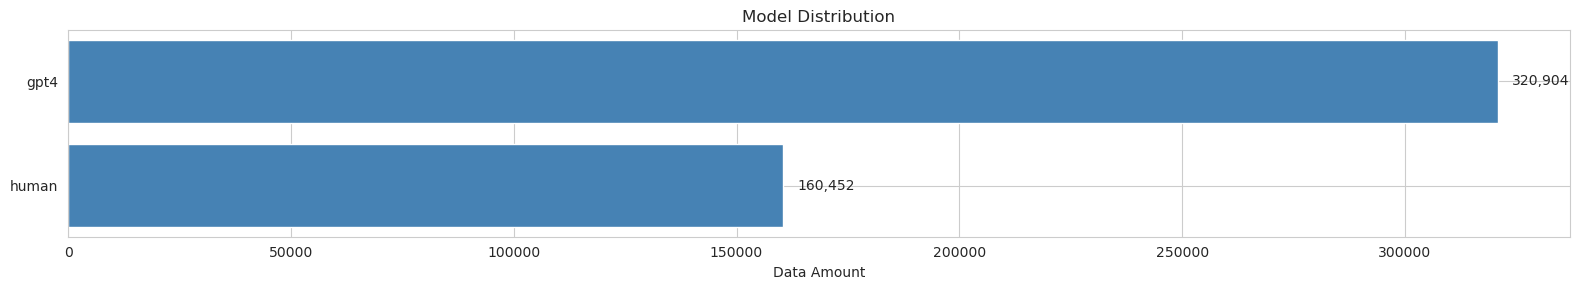

In [22]:
print("[3] Distribusi 'model'...")
model_dist, time_3 = measure_time(
    lambda: df.groupBy("model").count().orderBy(desc("count")).collect()
)
print(f"✅ Selesai dalam {time_3:.4f} detik")

models = [row['model'] for row in model_dist]
counts = [row['count'] for row in model_dist]
print(f"Jumlah nilai unik 'model': {len(models)}")

# Plot
plt.figure(figsize=(16, 3))
sns.set_style("whitegrid")
plt.barh(models, counts, color='steelblue')
plt.xlabel('Data Amount')
plt.title('Model Distribution')
plt.gca().invert_yaxis()
for i, count in enumerate(counts):
    plt.text(count + max(counts) * 0.01, i, f'{count:,}', va='center')
plt.tight_layout()
plt.show()

# Distribusi 'domain'

[4] Distribusi 'domain'...
✅ Selesai dalam 3.8675 detik


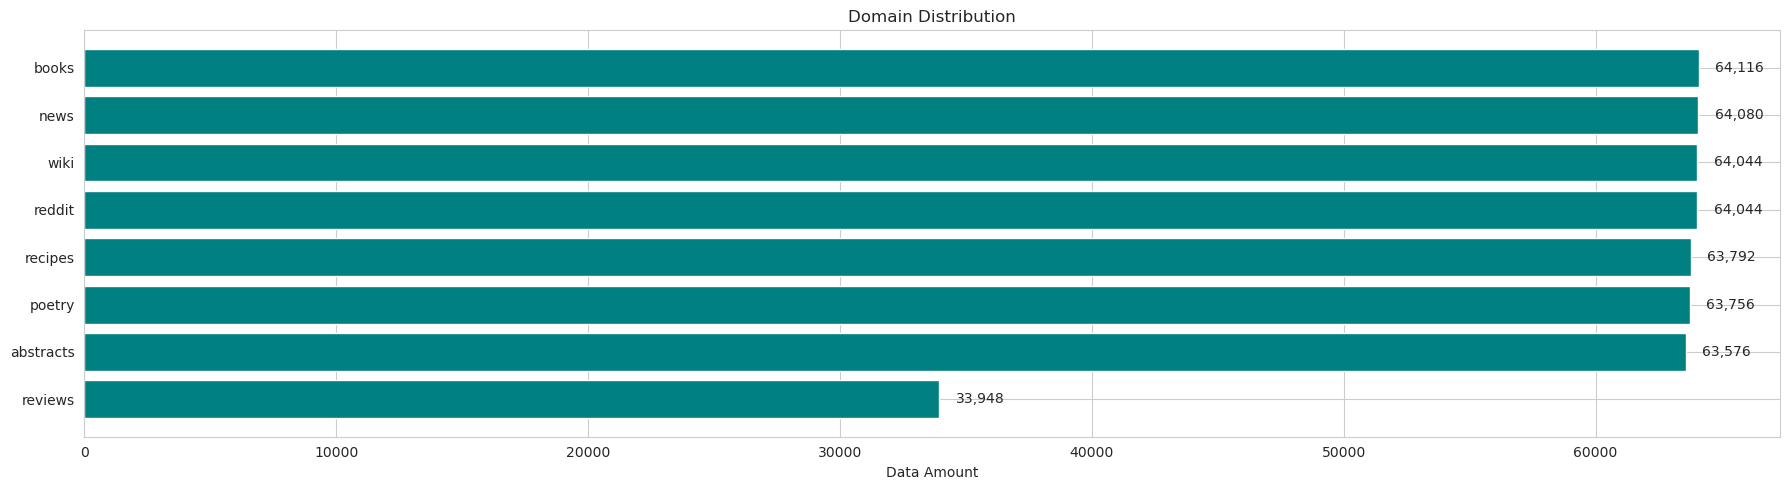

In [23]:
print("[4] Distribusi 'domain'...")
domain_dist, time_4 = measure_time(
    lambda: df.groupBy("domain").count().orderBy(desc("count")).collect()
)
print(f"✅ Selesai dalam {time_4:.4f} detik")

domains = [row['domain'] for row in domain_dist]
d_counts = [row['count'] for row in domain_dist]

plt.figure(figsize=(18, max(5, len(domains) * 0.25)))
sns.set_style("whitegrid")
plt.barh(domains, d_counts, color='teal')
plt.xlabel('Data Amount')
plt.title('Domain Distribution')
plt.gca().invert_yaxis()
for i, count in enumerate(d_counts):
    plt.text(count + max(d_counts) * 0.01, i, f'{count:,}', va='center')
plt.tight_layout()
plt.show()

# Distribusi 'attack'

[5] Distribusi 'attack'...
✅ Selesai dalam 3.9747 detik


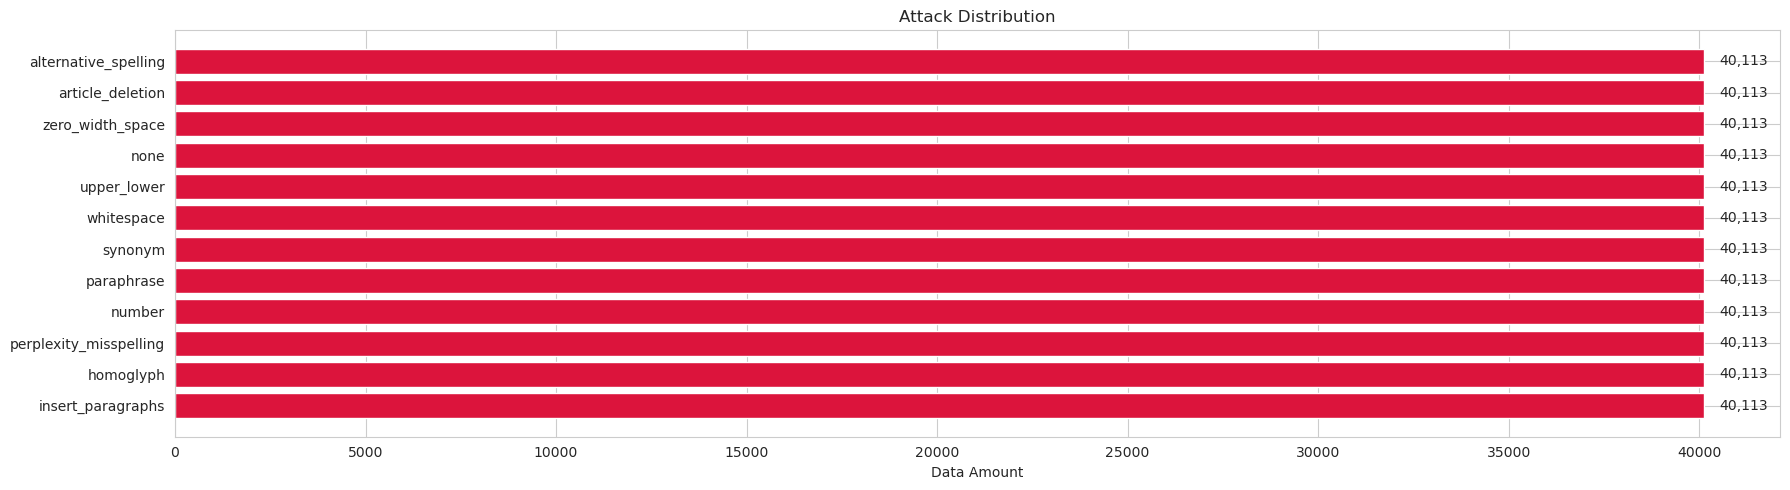

In [24]:
print("[5] Distribusi 'attack'...")
attack_dist, time_5 = measure_time(
    lambda: df.groupBy("attack").count().orderBy(desc("count")).collect()
)
print(f"✅ Selesai dalam {time_5:.4f} detik")

attacks = [row['attack'] for row in attack_dist]
a_counts = [row['count'] for row in attack_dist]

plt.figure(figsize=(18, max(5, len(attacks) * 0.25)))
sns.set_style("whitegrid")
plt.barh(attacks, a_counts, color='crimson')
plt.xlabel('Data Amount')
plt.title('Attack Distribution')
plt.gca().invert_yaxis()
for i, count in enumerate(a_counts):
    plt.text(count + max(a_counts) * 0.01, i, f'{count:,}', va='center')
plt.tight_layout()
plt.show()

# Distribusi Gabungan 'model_domain'

In [25]:
print("[6] Distribusi gabungan 'model_domain'...")
df_md = df.withColumn("model_domain", concat_ws("_", col("model"), col("domain")))
md_dist, time_6 = measure_time(
    lambda: df_md.groupBy("model_domain").count().orderBy(desc("count")).collect()
)
print(f"✅ Selesai dalam {time_6:.4f} detik")
print(f"Jumlah kombinasi unik 'model_domain': {len(md_dist)}")

[6] Distribusi gabungan 'model_domain'...
✅ Selesai dalam 4.2951 detik
Jumlah kombinasi unik 'model_domain': 16


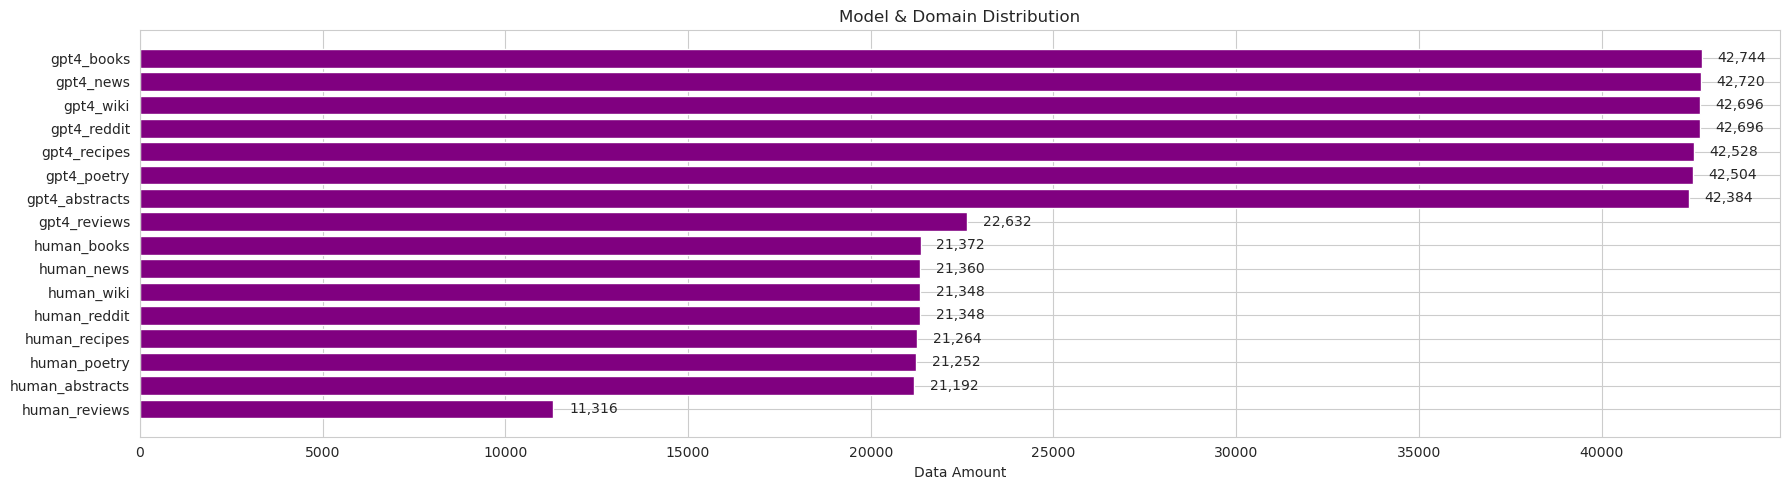

In [31]:
md_show = md_dist
md_labels = [row['model_domain'] for row in md_show]
md_vals = [row['count'] for row in md_show]

plt.figure(figsize=(18, 5))
sns.set_style("whitegrid")
plt.barh(md_labels, md_vals, color='purple')
plt.xlabel('Data Amount')
plt.title('Model & Domain Distribution')
plt.gca().invert_yaxis()
for i, count in enumerate(md_vals):
    plt.text(count + max(md_vals) * 0.01, i, f'{count:,}', va='center')
plt.tight_layout()
plt.show()

# Distribusi Gabungan 'model_attack'

In [33]:
print("[7] Distribusi gabungan 'model_attack'...")
df_ma = df.withColumn("model_attack", concat_ws("_", col("model"), col("attack")))
ma_dist, time_7 = measure_time(
    lambda: df_ma.groupBy("model_attack").count().orderBy(desc("count")).collect()
)
print(f"✅ Selesai dalam {time_7:.4f} detik")
print(f"Jumlah kombinasi unik 'model_attack': {len(ma_dist)}")

[7] Distribusi gabungan 'model_attack'...
✅ Selesai dalam 3.9657 detik
Jumlah kombinasi unik 'model_attack': 24


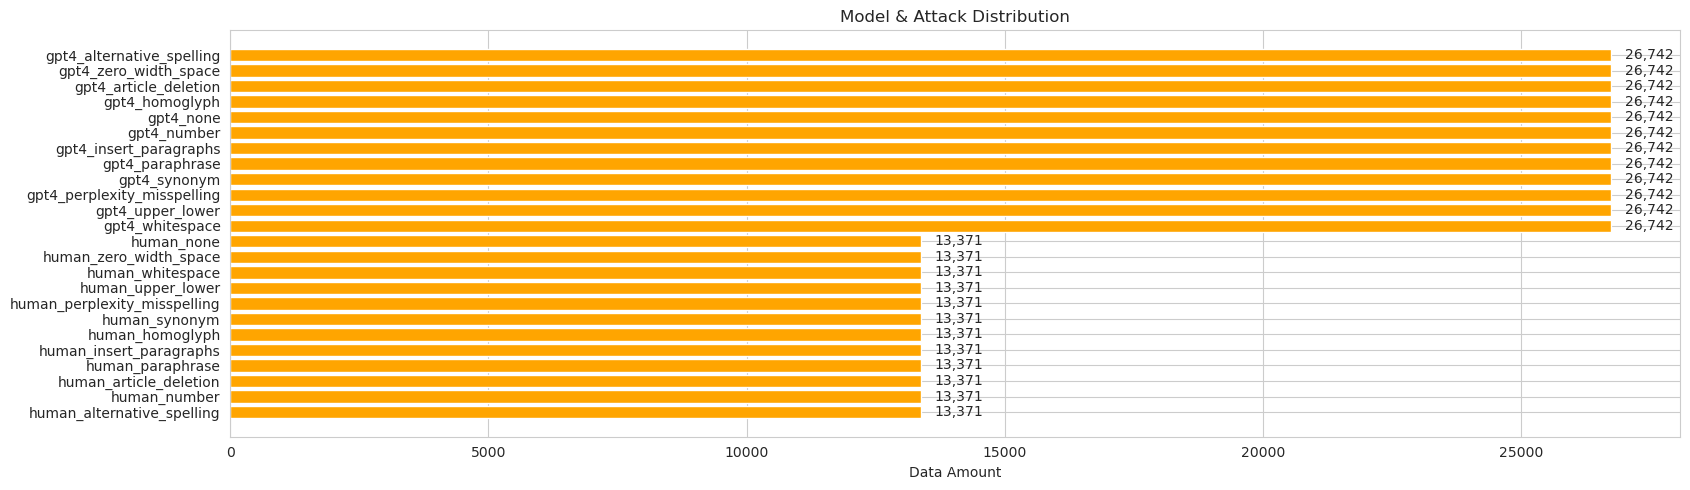

In [34]:
ma_show = ma_dist
ma_labels = [row['model_attack'] for row in ma_show]
ma_vals = [row['count'] for row in ma_show]

plt.figure(figsize=(17, 5))
sns.set_style("whitegrid")
plt.barh(ma_labels, ma_vals, color='orange')
plt.xlabel('Data Amount')
plt.title('Model & Attack Distribution')
plt.gca().invert_yaxis()
for i, count in enumerate(ma_vals):
    plt.text(count + max(ma_vals) * 0.01, i, f'{count:,}', va='center')
plt.tight_layout()
plt.show()

# Distribusi Gabungan 'model_domain_attack'

In [37]:
print("[8] Distribusi gabungan 'model_domain_attack'...")
df_mda = df.withColumn(
    "model_domain_attack",
    concat_ws("_", col("model"), col("domain"), col("attack"))
)
mda_dist, time_8 = measure_time(
    lambda: df_mda.groupBy("model_domain_attack").count().orderBy(desc("count")).collect()
)
print(f"✅ Selesai dalam {time_8:.4f} detik")
print(f"Jumlah kombinasi unik 'model_domain_attack': {len(mda_dist)}")

[8] Distribusi gabungan 'model_domain_attack'...
✅ Selesai dalam 4.2810 detik
Jumlah kombinasi unik 'model_domain_attack': 192


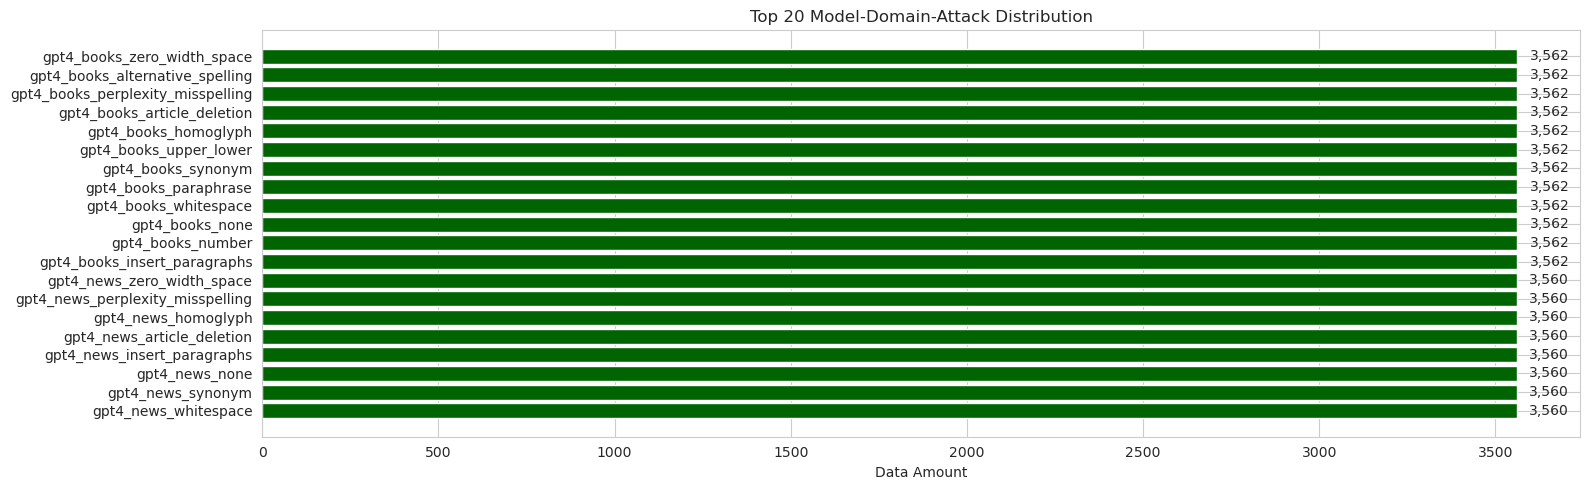

In [45]:
mda_show = mda_dist[:20] if len(mda_dist) > 10 else mda_dist
mda_labels = [row['model_domain_attack'] for row in mda_show]
mda_vals = [row['count'] for row in mda_show]

plt.figure(figsize=(16, 5))
sns.set_style("whitegrid")
plt.barh(mda_labels, mda_vals, color='darkgreen')
plt.xlabel('Data Amount')
plt.title('Top 20 Model-Domain-Attack Distribution')
plt.gca().invert_yaxis()
for i, count in enumerate(mda_vals):
    plt.text(count + max(mda_vals) * 0.01, i, f'{count:,}', va='center')
plt.tight_layout()
plt.show()

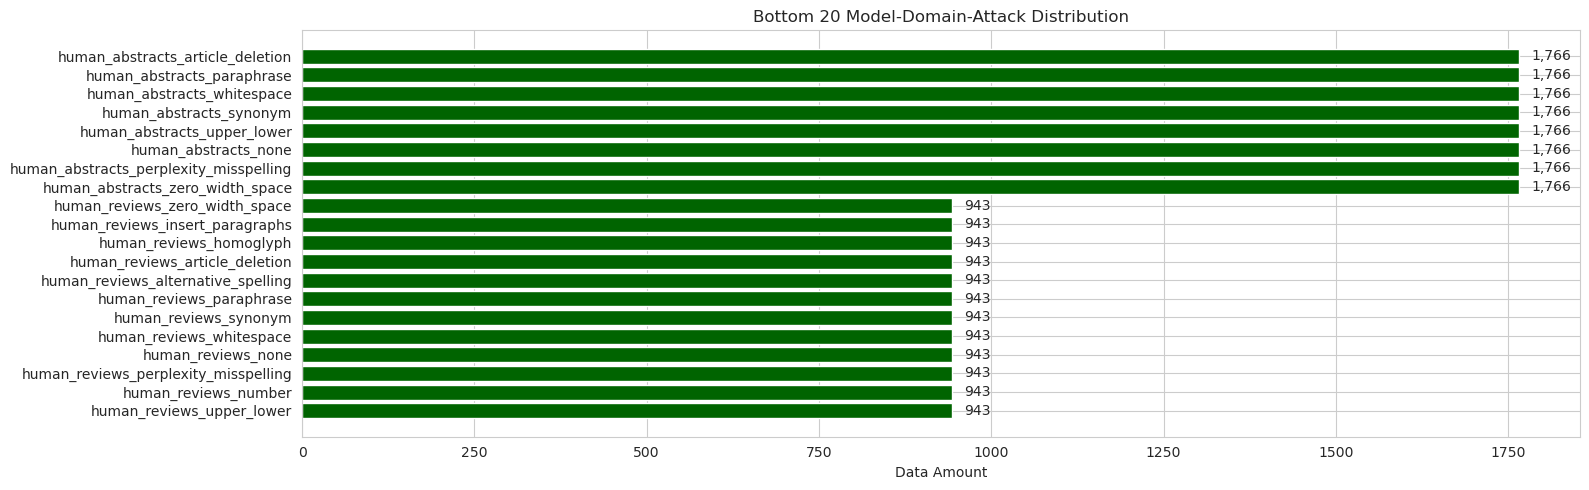

In [46]:
mda_show = mda_dist[len(mda_dist) - 20:]
mda_labels = [row['model_domain_attack'] for row in mda_show]
mda_vals = [row['count'] for row in mda_show]

plt.figure(figsize=(16, 5))
sns.set_style("whitegrid")
plt.barh(mda_labels, mda_vals, color='darkgreen')
plt.xlabel('Data Amount')
plt.title('Bottom 20 Model-Domain-Attack Distribution')
plt.gca().invert_yaxis()
for i, count in enumerate(mda_vals):
    plt.text(count + max(mda_vals) * 0.01, i, f'{count:,}', va='center')
plt.tight_layout()
plt.show()

# Panjang Teks 'generation'

In [48]:
print("[9] Panjang teks pada kolom 'generation'...")
# Catatan: 'generation' berisi label 'human'/'machine', bukan teks panjang
gen_len_stats, time_9 = measure_time(
    lambda: df.select(
        pyspark.sql.functions.min(length(col("generation"))).alias("min_len"),
        pyspark.sql.functions.max(length(col("generation"))).alias("max_len")
    ).collect()
)
stats = gen_len_stats[0]
print(f"✅ Min: {stats['min_len']}, Max: {stats['max_len']} | Waktu: {time_9:.4f} detik")

[9] Panjang teks pada kolom 'generation'...
✅ Min: 3, Max: 140088 | Waktu: 4.8290 detik


# 100 Contoh Data Acak

In [49]:
print("[10] Menampilkan 100 contoh data acak...")
sample_pd, time_10 = measure_time(
    lambda: df.orderBy(rand()).limit(100).toPandas()
)
print(f"✅ Selesai dalam {time_10:.4f} detik")
print("Contoh data:")
display(sample_pd)

[10] Menampilkan 100 contoh data acak...
✅ Selesai dalam 10.1605 detik
Contoh data:


,attack,domain,features,generation,id,model
0,perplexity_misspelling,news,"[0.0096368445, 0.0160347875, 0.004285547, 0.01...",Four-times Grand Slam champion Kim Clijsters h...,260cbc9b-9454-440e-bef7-43972252230b,gpt4
1,upper_lower,wiki,"[0.0143643338, -0.0149914687, -0.0230505634, -...",Colossae (; Greek: κολοσσαί) was an ancient ci...,f4129067-23d2-42c8-8692-2c9c8b1c7df6,human
2,perplexity_misspelling,abstracts,"[-0.0726532862, -0.0004931045, 0.0252992846, 0...",This academic paper delves into an in-depth st...,a9ef78fc-d6c2-4669-848f-176de75fcc2f,gpt4
3,upper_lower,reddit,"[-0.0335363559, 0.0028122496, -0.0063733659, -...","Bonjour À tous,\n\nJ'écris aujourd'hui pour pa...",167874ae-ff0c-4da7-b698-e9fab68726c5,gpt4
4,alternative_spelling,reviews,"[-0.02140438, 0.0076754871, -0.004642054, 0.06...","I love this movie! It was so adorable, so char...",c493d39a-1d7b-4d02-b10a-89d54fb4e5b7,human
...,...,...,...,...,...,...
95,none,reddit,"[-0.0294878073, -0.0041772728, 0.0162737183, 0...",So I recently was dumped by my girlfriend duri...,457903a5-fb0b-4e99-aecb-ef5dd7bc4d37,human
96,paraphrase,wiki,"[-0.0023146272, 0.0055364547, -0.0004942613, 0...","Bruce Eric Kaplan, better known as BEK, is an ...",36bc7f22-3d5a-460b-b7a4-c6380514251b,gpt4
97,synonym,reddit,"[-0.0078521715, 0.0183165483, 0.0130566182, 0....","Growing up, my mother and I were reared in a f...",5ed221cf-f352-4e53-8eec-ac3e9a7b514b,gpt4
98,synonym,recipes,"[-0.0140135353, 0.0176860858, -0.0060971626, 0...",6 large eggs separated\n3/4 cup vegetable oil\...,73ff6227-4f72-4fbd-9cf2-a90fe4cf4780,human


In [50]:
print("Menghentikan SparkSession...")
spark.stop()
print("✅ SparkSession dihentikan.")

Menghentikan SparkSession...
✅ SparkSession dihentikan.


In [55]:
_ = u.display_table(sample_pd.to_dict('records'), hidden_columns=['features'], n_items=[5, 5])

attack,domain,generation,id,model
perplexity_misspelling,news,"Four-times Grand Slam champion Kim Clijsters has expressed her hope of participating in the Australian Open, having to overcome recent health setbacks. The 38-year-old Belgian had a hiatus from the sport due to recurring illnesses and injuries but announced her plans for a comeback in September 2019. However, injuries continued to plague her return. Clijsters's determination to compete in the Australian Open is unwavering, despite these physical challenges. “I will not go to Australia unless I am 100% ready,” she told reporters, emphasising her commitment to ensuring she is fully fit before entering major competitions again. A former world number one, Clijsters won the US Open in 2005, 2009 and 2010, with her most recent Grand Slam victory at the Australian Open in 2011. Clijsters had to withdraw from her planned comeback in 2020 due to a knee injury. She was then set to take part in the Miami Open in March this year but was forced to pull out after testing positive for Covid-19. ""It's a step-by-step process,"" Clijsters explained. ""I knew it wasn't going to be easy comming back after such a long break."" Clijsters's former rival, Serena Williams, who is currently ranked number eight in the world, applauded her persistence. ""Kim is a fighter. Knowing her, she will do everything she can to be ready for Australia,"" Williams said. The Australian Open, typically considered the initial major tournament of the tennis season, is currently scheduled for 17-30 January 2023. Despite constraints due to the ongoing Covid-19 pandemic, an estimated 50% capacity of spectators is planned. Wether or not Clijsters will be part of the players stepping onto the court in Melbourne Park remains to be seen, and is undoubtedly a topic of grat interest to tennis fans worldwide. Regardless, her steadfast commitment to getting back to a competitive level is evident. Restoring her health and stamina for potential success at the Australian Open appears to be her deciding factor, demonstrating her competitive spirit and dedication to the sport.",260cbc9b-9454-440e-bef7-43972252230b,gpt4
upper_lower,wiki,"Colossae (; Greek: κολοσσαί) was an ancient city of Phrygia in Asia Minor, and one of the most celebrated cities of southern Anatolia (modern turkey). The Epistle to the Colossians, an early Christian text which identifies its author as paul the Apostle, is addressed to the church in Colossae. A significant city from the 5th century BC onwards, it had dwindled in importance by the time of Paul, but was notable for the existence of its local angel cult. It was part of the roman – and then Byzantine – province of Phrygia Pacatiana, before being destroyed in 1192/3 and its population relocating to nearby Chonae (Chonai, modern day Honaz). Location and Geography Colossae was Located in Phrygia, in Asia Minor. It was located 15 km southeast of Laodicea on the road through the Lycus Valley near the Lycus River at the foot of Mt. Cadmus, the highest mountain in Turkey's western Aegean Region, and between the cities Sardeis and Celaenae, and southeast of the ancient city of Hierapolis. At Colossae, herodotus describes how, ""the river Lycos falls into an opening of the earth and disappears from view, and then After an interval of about five furlongs it comes up to View again, and This river also flows into the Maiander."" Despite a treacherously ambiguous cartography and history, Colossae has been Clearly distinguished in modern research from nearby Chonai (Χῶναι), now called Honaz, with What remains of the buried ruins of Colossae (""the mound"") lying 3 km to the north of Honaz.",f4129067-23d2-42c8-8692-2c9c8b1c7df6,human
perplexity_misspelling,abstracts,"This academic paper delves into an in-depth study of the generalized colouring numbers of graphs that exclude a fixed minor. The text elaborates on the correlation between the vertex colouring number and the structural graphs aspect ratio. We po